In [1]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import imageio
import copy
from scipy.signal import convolve

def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def gradient(image):
    """ ==========
    Compute gradient of the image
    ========== """
    g_mag = np.zeros_like(image)
    g_theta = np.zeros_like(image)
    x_dir = np.array([-1/2, 0, 1/2]).reshape((1,3))
    y_dir = np.array([-1/2, 0, 1/2]).reshape((3,1))
#     x_dir = np.array([x_dir]*3).reshape(3,3)
#     y_dir = np.array([y_dir]*3).reshape(3,3)
    dx = convolve(image,x_dir,mode="same")
    dy = convolve(image,y_dir,mode="same")
    return dx,dy

In [ ]:
def homography(im1,H1):
    x_max = im1.shape[1]
    y_max = im1.shape[0]
    
    for i in range(im1.shape[0]):
        width = np.arange(im1.shape[1])
        hight = np.ones(im1.shape[1])*i
        output_location = from_homog(H1@to_homog(np.vstack((width,hight)))).astype(int)
        x_max = output_location[0,:].max() if output_location[0,:].max()>x_max else x_max
        y_max = output_location[1,:].max() if output_location[1,:].max()>y_max else y_max
    
    rectified_im1 = np.zeros((y_max,x_max,3))
    for i in range(rectified_im1.shape[0]):
        width = np.arange(rectified_im1.shape[1])
        hight = np.ones(rectified_im1.shape[1])*i
        rectified_location = from_homog(np.linalg.inv(H1)@to_homog(np.vstack((width,hight)))).astype(int)    
        x = np.maximum(np.minimum(rectified_location[0,:],np.ones(hight.shape)*(im1.shape[1]-1)),np.zeros(hight.shape))
        y = np.maximum(np.minimum(rectified_location[1,:],np.ones(width.shape)*(im1.shape[0]-1)),np.zeros(width.shape))
        rectified_im1[hight.astype(int),width.astype(int)] = im1[y.astype(int),x.astype(int)]
    return rectified_im1.astype(int)

In [119]:
I1 = imageio.imread("./p4/matrix/matrix0.png")
I2 = imageio.imread("./p4/matrix/matrix1.png")
cor1 = np.load("./p4/matrix/cor1.npy")
cor2 = np.load("./p4/matrix/cor2.npy")
I3 = imageio.imread("./p4/warrior/warrior0.png")
I4 = imageio.imread("./p4/warrior/warrior1.png")
cor3 = np.load("./p4/warrior/cor1.npy")
cor4 = np.load("./p4/warrior/cor2.npy")

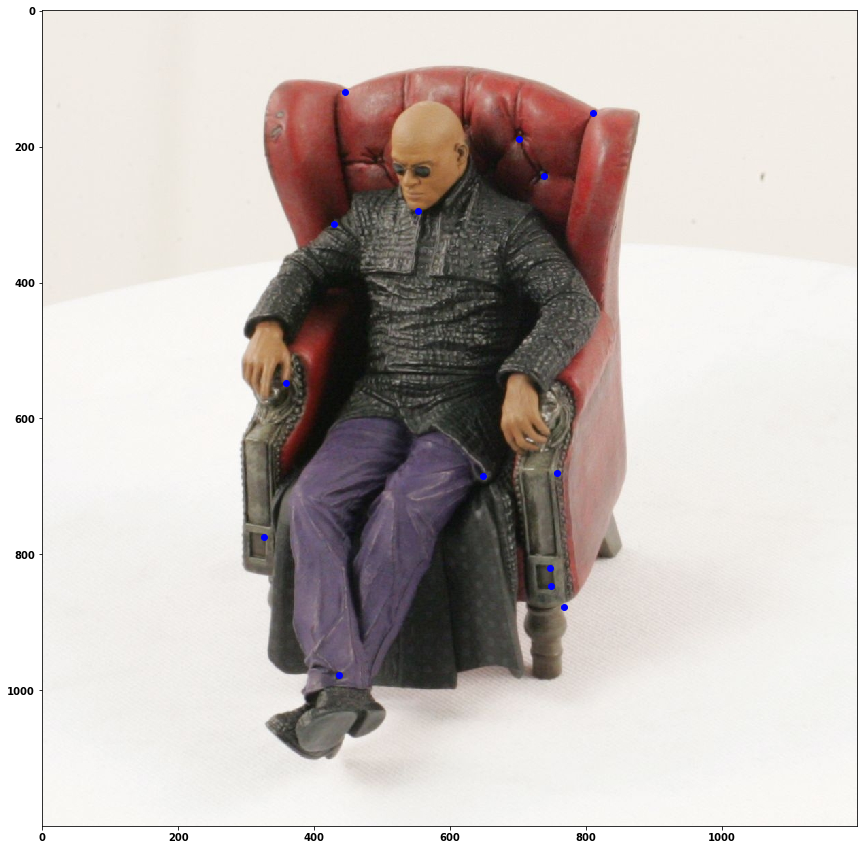

In [124]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(I1)
plt.scatter(cor1[0,:], cor1[1,:], s=36, edgecolors='b', facecolors='b')
plt.show()

In [90]:
import numpy.ma as ma

x = np.array([1, 2, 3, -1, 5])
ma.masked_array(x, mask=[0, 0, 0, 1, 0])

masked_array(data=[1, 2, 3, --, 5],
             mask=[False, False, False,  True, False],
       fill_value=999999)

In [ ]:
np.array(list(zip(n_corner[1],n_corner[0])))

In [109]:
cor1[0]

array([811., 446., 553., 430., 359., 649., 758., 768., 437., 747., 748.,
       327., 701., 739.])

In [83]:
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])

In [102]:
img1 = np.arange(3*14).reshape(3,14)
img1

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
       [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]])

In [103]:
img1.argmax()

41

In [104]:
img1.argmax()//img1.shape[1]

2

In [111]:
img1[1,:] = 0
img1

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]])

In [105]:
img1.argmax()%img1.shape[1]

13

In [ ]:
def naive_matching(img1, img2, corners1, corners2, R, NCCth):
    """Compute NCC given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Corners in image 1 (nx2)
        corners2: Corners in image 2 (nx2)
        R: NCC matching radius
        NCCth: NCC matching score threshold

    Returns:
        NCC matching result a list of tuple (c1, c2), 
        c1 is the 1x2 corner location in image 1, 
        c2 is the 1x2 corner location in image 2. 

    """
    matching = []
    ncc = np.zeros([corners1.shape[0], corners2.shape[0]])
    temp = np.ones([corners1.shape[0], corners2.shape[0]])*-1
    
    for i in range(corners1.shape[0]):
        for j in range(corners2.shape[0]):
            ncc[i][j] = ncc_match(img1,img2,corners1[i],corners2[j],R)
    
    max_match = ncc.max(axis=1)
    max_match_idx = ncc.argmax(axis=1)
    
    for i in range(corners1.shape[0]):
        col_max = ncc[:,i].max()
        next_best = max(max_match[i],col_max)
        if (1-max_match[i]) < (1-next_best)*0.8:
            matching.append((corners1[i],corners2[max_match_idx[i]]))
            
    
    
    for i in range(corners1.shape[0]):
        if max_match[i] > NCCth:
            matching.append((corners1[i],corners2[max_match_idx[i]]))
    return matching

In [78]:
output_pixel_location = np.array([-194.55,118.29])

In [89]:
img1[:,1].max()

8

In [88]:
np.ones([3, 3])*-1

array([[-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.]])

In [87]:
img1

array([[1, 2, 3, 4],
       [4, 5, 6, 8],
       [7, 8, 9, 4]])

In [85]:
img2

array([[1, 2, 1, 3],
       [6, 5, 4, 4],
       [9, 8, 7, 3]])

In [79]:
x = max(0,min(int(output_pixel_location[0]),600-1))

In [80]:
x

0

In [81]:
I1.shape

(1200, 1200, 3)

In [35]:
cor1.shape

(3, 14)

In [65]:
h = np.arange(9).reshape(3,3)
g = np.arange(3*14).reshape(3,14)

In [66]:
h

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [69]:
from_homog(h@to_homog(c))

array([[0.25      , 0.2       , 0.18181818, 0.17241379, 0.16666667,
        0.1627907 , 0.16      , 0.15789474, 0.15625   , 0.15492958,
        0.15384615, 0.15294118, 0.15217391],
       [0.625     , 0.6       , 0.59090909, 0.5862069 , 0.58333333,
        0.58139535, 0.58      , 0.57894737, 0.578125  , 0.57746479,
        0.57692308, 0.57647059, 0.57608696]])

In [72]:
d = to_homog(c)
d[d[0,:].astype(int),d[1,:].astype(int)]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [73]:
d[0,:].astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
d[1,:].astype(int)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [68]:
def from_homog(points_homog):
    if points_homog.ndim == 1:
        return (points_homog/points_homog[-1])[:-1]
    else:
        return (points_homog/points_homog[-1,:])[:-1,:] 

In [42]:
c = np.zeros(a.shape)

In [76]:
c

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]])

In [45]:
np.maximum(a,c)

array([[0., 1., 2.],
       [3., 4., 5.],
       [6., 7., 8.]])

In [75]:
np.minimum(a,0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [63]:
a = np.arange(13)
b = np.ones(13)*0
c = np.vstack((b,a))

In [64]:
to_homog(c)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [55]:
def to_homog(points):
    if points.ndim == 1:
        return np.append(points,1)
    else:
        return np.vstack((points, [1]*points.shape[1]))

In [51]:
b = np.ones(3)*0

array([0., 0., 0.])

In [38]:
I1[0].shape

(1200, 3)

In [41]:
I1[0,0,:].shape

(3,)

In [30]:
b

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
       [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]])

In [33]:
a@b[:,0]

array([ 70, 196, 322])

In [34]:
a@b

array([[ 70,  73,  76,  79,  82,  85,  88,  91,  94,  97, 100, 103, 106,
        109],
       [196, 208, 220, 232, 244, 256, 268, 280, 292, 304, 316, 328, 340,
        352],
       [322, 343, 364, 385, 406, 427, 448, 469, 490, 511, 532, 553, 574,
        595]])

In [117]:
x = np.arange(2,11)
x.shape

(9,)

In [118]:
11-2

9

In [128]:
np.zeros(2)

array([0., 0.])

In [ ]:
def plot_epipolar_lines(img1,img2, cor1, cor2):
    """Plot epipolar lines on image given image, corners

    Args:
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)

    """
    F = fundamental_matrix(cor1,cor2)
    e1,e2 = compute_epipole(F)
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(221)
    ax1.imshow(img1, cmap='gray')
    ax1.scatter(cor1[0,:], cor1[1,:], s=36, edgecolors='b', facecolors='b')
    for i in range(cor1.shape[1]):
        x1 = img1.shape[1]
        slope1 = (e1[1]-cor1[1,i])/(e1[0]-cor1[0,i])
        y1_intercept = cor1[1,i]-slope1*cor1[0,i]
        x1_intercept = slope1*x1+y1_intercept
        ax1.plot([0,x1],[y1_intercept,x1_intercept], color = 'b')
        ax1.axis([0,img1.shape[1],img1.shape[0],0])

    ax2 = fig.add_subplot(222)
    ax2.imshow(img2, cmap='gray')
    ax2.scatter(cor2[0,:], cor2[1,:], s=36, edgecolors='b', facecolors='b')
    for i in range(cor2.shape[1]):
        x2 = img2.shape[1]
        slope2 = (e2[1]-cor2[1,i])/(e2[0]-cor2[0,i])
        y2_intercept = cor2[1,i]-slope2*cor2[0,i]
        x2_intercept = slope2*x2+y2_intercept
        ax2.plot([0,x2],[y2_intercept,x2_intercept], color = 'b')
        ax2.axis([0,img2.shape[1],img2.shape[0],0])
    plt.show()

In [125]:
cor1 = np.load("./p4/dino/cor1.npy")
cor2 = np.load("./p4/dino/cor2.npy")

In [127]:
cor1[[0,1],:]

array([[ 695.,  848.,  609., 1522., 1111., 1030.,  921.,  868.,  969.,
         841.,  750.,  753.,  963.],
       [1023.,  203.,  168.,  703.,  824.,  649., 1298.,  504.,  734.,
         776.,  719.,  686.,  848.]])

In [26]:
#         l1 = F@cor2[:,i]
#         x1_intercept = -(l1[0]*x1+l1[2])/l1[1]
#         y1_intercept = -l1[2]/l1[1]
#         ax1.plot([x1,0],[x1_intercept,y1_intercept], color = 'b')
#         print(x1_intercept,y1_intercept)
#         ax1.axis([0,img1.shape[1],img1.shape[0],0])
#         print(x1_intercept,y1_intercept)

In [ ]:

def large_iamge(img,factor=20):
    ts = img.shape
    source_points = np.array([[0,0],[ts[1],0],[ts[1],ts[0]],[0,ts[0]]]).T
    target_points = np.array([[0,0],[ts[1]*factor,0],[ts[1]*factor,ts[0]*factor],[0,ts[0]*factor]]).T
    
    e1 = np.array([[1],[0],[0]])
    e2 = np.array([[0],[1],[0]])
    e3 = np.array([[0],[0],[1]])
    e4 = np.array([[1],[1],[1]])
    lambda_1 = np.linalg.solve(source_points[:,0:3],source_points[:,-1])
    lambda_2 = np.linalg.solve(target_points[:,0:3],target_points[:,-1])
    H_1_inv = lambda_1*source_points[:,0:3]
    H_2_inv = lambda_2*target_points[:,0:3]
    H = H_2_inv@np.linalg.inv(H_1_inv)
    
    for i in range(im1.shape[0]):
        width = np.arange(im1.shape[1])
        hight = np.ones(im1.shape[1])*i
        rectified_location = from_homog(H1@to_homog(np.vstack((width,hight)))).astype(int)      
        x = np.maximum(np.minimum(rectified_location[0,:],np.ones(hight.shape)*(im1.shape[0]-1)),np.zeros(hight.shape))
        y = np.maximum(np.minimum(rectified_location[1,:],np.ones(width.shape)*(im1.shape[1]-1)),np.zeros(width.shape))
        rectified_im1[y.astype(int),x.astype(int),:] = im1[hight.astype(int),width.astype(int),:]
    
    
    return 
    

In [25]:
cor2.shape

(3, 13)

In [15]:
a,b,c = np.linalg.svd(F)

In [19]:
c.T[:,-1]

array([9.44630372e-01, 3.28136099e-01, 4.01785211e-04])

In [13]:
F = fundamental_matrix(cor1,cor2)

[[ 1.05556938e+00 -7.11353543e+00 -2.04753770e+00]
 [ 8.16035779e+00 -2.66124160e-02 -6.01245295e+01]
 [-6.37979846e+00  5.71093078e+01  1.00000000e+00]]


In [9]:
np.linalg.matrix_rank(F)

2

In [24]:
null_space(F)/null_space(F)[2,:]

array([[2.35108298e+03],
       [8.16695313e+02],
       [1.00000000e+00]])

In [14]:
from scipy.linalg import null_space
null_space(F)

array([[9.44630372e-01],
       [3.28136099e-01],
       [4.01785211e-04]])

In [296]:
def show_corners_result(imgs, corners):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(221)
    ax1.imshow(imgs, cmap='gray')
    ax1.scatter(corners[:, 0], corners[:, 1], s=36, edgecolors='r', facecolors='none')

#     ax2 = fig.add_subplot(222)
#     ax2.imshow(imgs[1], cmap='gray')
#     ax2.scatter(corners[1][:, 0], corners[1][:, 1], s=36, edgecolors='r', facecolors='none')
#     plt.show()

In [12]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
from scipy.io import loadmat

def compute_fundamental(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] 

        Returns:
        Fundamental Matrix (3x3)

    """
    
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
        
    A = np.zeros((n,9))
    A = (np.tile(x1,(3,1)) * x2.repeat(3,0)).T
    
    U_a,S_a,V_a = np.linalg.svd(A)
    f = V_a[-1].reshape(3,3)
    
    U_f,S_f,V_f = np.linalg.svd(f)
    S_f[2] = 0
    
    F = U_f@np.diag(S_f)@V_f
    return F
    
def fundamental_matrix(x1,x2):
    # Normalization of the corner points is handled here
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)
    print(F/F[2,2])

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]

In [297]:
# detect corners on warrior and matrix image sets
# adjust your corner detection parameters here
nCorners = 20
smoothSTD = 0.5
imgs_mat = []
imgs_war = []
grayimgs_mat = []
grayimgs_war = []
# Read the two images and convert it to Greyscale
img_mat = imageio.imread('p4/matrix/matrix' + str(1) + '.png')
imgs_mat.append(img_mat) 
grayimgs_mat.append(rgb2gray(img_mat))
    # Comment above line and uncomment below line to
    # downsize your image in case corner_detect runs slow in test 
    #grayimgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    # if you unleash the power of numpy you wouldn't need to downsize, it'll be fast
#     img_war = imageio.imread('p4/warrior/warrior' + str(i) + '.png')
#     imgs_war.append(img_war)
#     grayimgs_war.append(rgb2gray(img_war))
    
windowSize = int(6*smoothSTD)
if windowSize%2==0: windowSize += 1
# crns_mat = []
# crns_war = []
print ("SmoothSTD:", smoothSTD, "WindowSize:", windowSize)
# crns_mat.append(corner_detect(grayimgs_mat[0], nCorners, smoothSTD,windowSize))
    #show_corners_result(imgs_mat, crns_mat) #uncomment this to show your output!
    #show_corners_result(imgs_war, crns_war)

SmoothSTD: 0.5 WindowSize: 3


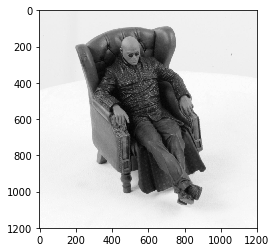

In [298]:
plt.imshow(grayimgs_mat[0],cmap="gray")
plt.show()

In [384]:
def get_lambda(img,cx,cy,cxy,window_range):
    lambda_mat = np.zeros(img.shape)
    c_x,c_y,c_xy = np.zeros(cx.shape),np.zeros(cy.shape),np.zeros(cxy.shape)
    row,col = img.shape
    padded_x = np.pad(cx,window_range,mode="edge")
    padded_y = np.pad(cy,window_range,mode="edge")
    padded_xy = np.pad(cxy,window_range,mode="edge")
    for i in range(row):
        for j in range(col):
            c_x[i,j] = padded_x[i:i+2*window_range+1,j:j+2*window_range+1].sum()
            c_y[i,j] = padded_y[i:i+2*window_range+1,j:j+2*window_range+1].sum()
            c_xy[i,j] = padded_xy[i:i+2*window_range+1,j:j+2*window_range+1].sum()
            c_mat = np.array([[c_x[i,j],c_xy[i,j]],[c_xy[i,j],c_y[i,j]]])
            a,_ = np.linalg.eig(c_mat)
            lambda_mat[i,j] = min(a)
    lambda_mat[0,0] = 0
    return lambda_mat

In [359]:
def get_lambda_2(img,cx,cy,cxy,window_range):
    lambda_mat = np.zeros(img.shape)
    c_x,c_y,c_xy = np.zeros(cx.shape),np.zeros(cy.shape),np.zeros(cxy.shape)
    row,col = img.shape
    for i in range(window_range,row-window_range):
        for j in range(window_range,col-window_range):
            i_start = i-window_range
            i_end = i+window_range+1
            j_start = j-window_range
            j_end = j+window_range+1
            c_x[i,j] = cx[i_start:i_end,j_start:j_end].sum()
            c_y[i,j] = cy[i_start:i_end,j_start:j_end].sum()
            c_xy[i,j] = cxy[i_start:i_end,j_start:j_end].sum()
            c_mat = np.array([[c_x[i,j],c_xy[i,j]],[c_xy[i,j],c_y[i,j]]])
            a,_ = np.linalg.eig(c_mat)
            lambda_mat[i-window_range,j-window_range] = min(a)
    return lambda_mat

In [351]:
def nms(mat,window_size):
    """ ==========
    Discreted non-maximum suppression
    ========== """
    rows,cols = mat.shape
    image = np.zeros((rows,cols))
    window_range = window_size//2
    padded_mat = np.pad(mat,window_range,mode="symmetric")
    for i in range(window_range,rows-window_range):
        for j in range(window_range,cols-window_range):
            i_start = i-window_range
            i_end = i+window_range+1
            j_start = j-window_range
            j_end = j+window_range+1
            window = mat[i_start:i_end,j_start:j_end]
            max_value = window.max(axis=(0,1))
            if max_value != mat[i-window_range,j-window_range]:
                image[i-window_range,j-window_range] = 0
            else:
                image[i-window_range,j-window_range] = max_value
    return image

In [398]:
def nms_2(mat,window_size):
    """ ==========
    Discreted non-maximum suppression
    ========== """
    rows,cols = mat.shape
    image = np.zeros((rows,cols))
    window_range = window_size//2
    for i in range(window_range,rows-window_range):
        for j in range(window_range,cols-window_range):
            i_start = i-window_range
            i_end = i+window_range+1
            j_start = j-window_range
            j_end = j+window_range+1
            window = mat[i_start:i_end,j_start:j_end]
            max_value = window.max(axis=(0,1))
            if max_value != mat[i,j]:
                image[i,j] = 0
            else:
                image[i,j] = max_value
    return image

In [334]:
def n_strongest(img, n):
    uniques = np.unique(img)
    threshold = uniques[-n-1]
    return np.where(img > threshold)

In [303]:
corners = np.zeros((nCorners, 2))
window_range = windowSize//2
filtered_img = gaussian_filter(grayimgs_mat[0],smoothSTD)
dx,dy = gradient(filtered_img)

In [369]:
padded_org_img = np.pad(filtered_img,window_range,mode="symmetric")
pad_dx,pad_dy = gradient(padded_org_img)
pad11,pad22,pad12 = pad_dx**2,pad_dy**2,pad_dx*pad_dy

In [380]:
a = np.pad(filtered_img,window_range, 'constant')

In [381]:
a

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 235.811     , 235.811     , ..., 237.811     ,
        237.811     ,   0.        ],
       [  0.        , 235.811     , 235.811     , ..., 237.811     ,
        237.811     ,   0.        ],
       ...,
       [  0.        , 247.77316063, 247.04819588, ..., 246.65389735,
        246.5699869 ,   0.        ],
       [  0.        , 247.1660346 , 246.97567338, ..., 245.78368004,
        245.08149111,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [ ]:
def get_lambda_3(img,cx,cy,cxy,window_range):
    lambda_mat = np.zeros(img.shape)
    c_x,c_y,c_xy = np.zeros(cx.shape),np.zeros(cy.shape),np.zeros(cxy.shape)
    row,col = img.shape
    for i in range(window_range,row-window_range):
        for j in range(window_range,col-window_range):
            i_start = i-window_range
            i_end = i+window_range+1
            j_start = j-window_range
            j_end = j+window_range+1
            c_x[i,j] = cx[i_start:i_end,j_start:j_end].sum()
            c_y[i,j] = cy[i_start:i_end,j_start:j_end].sum()
            c_xy[i,j] = cxy[i_start:i_end,j_start:j_end].sum()
            c_mat = np.array([[c_x[i,j],c_xy[i,j]],[c_xy[i,j],c_y[i,j]]])
            a,_ = np.linalg.eig(c_mat)
            lambda_mat[i-window_range,j-window_range] = min(a)
    return lambda_mat

In [304]:
c_11 = dx**2
c_22 = dy**2
c_12 = dx*dy

In [318]:
dyy,dxx = np.gradient(filtered_img)
c_111 = dxx**2
c_222 = dyy**2
c_1212 = dxx*dyy

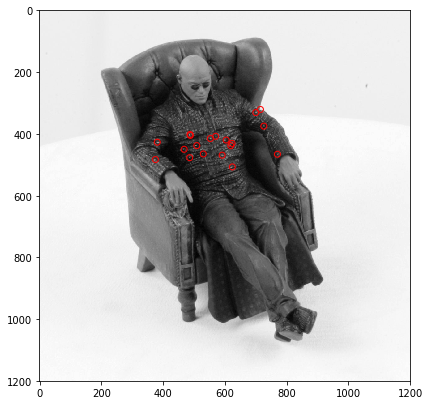

In [326]:
check = get_lambda(filtered_img,c_111,c_222,c_1212,window_range)
nms_resluts = nms(check,windowSize)

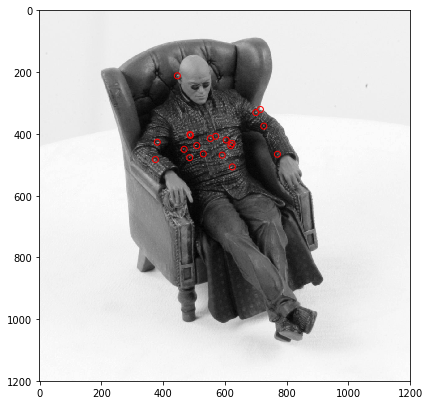

In [336]:
n_corner = n_strongest(nms_resluts,20)
corners = np.array(list(zip(n_corner[1],n_corner[0])))
show_corners_result(grayimgs_mat[0],corners)

In [337]:
corners.shape

(20, 2)

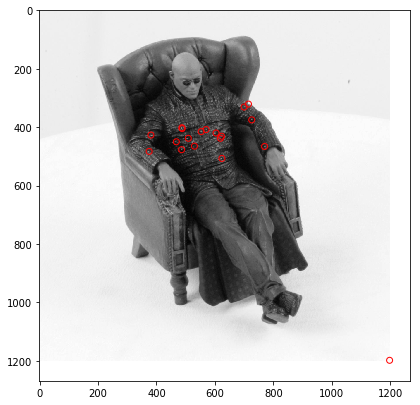

In [327]:
check_2 = get_lambda(filtered_img,c_11,c_22,c_12,window_range)
nms_resluts_2 = nms(check_2,windowSize)
n_corner_2 = n_strongest(nms_resluts_2,20)
corners_2 = np.array(list(zip(n_corner_2[1],n_corner_2[0])))
show_corners_result(grayimgs_mat[0],corners_2)

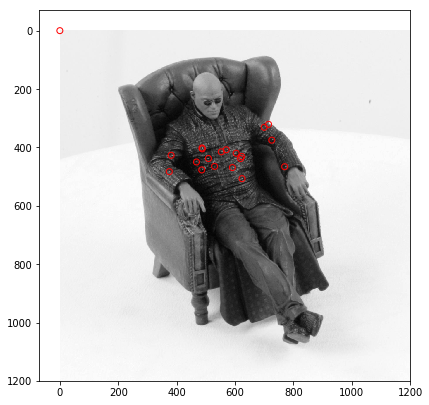

In [370]:
check_2 = get_lambda_2(filtered_img,pad11,pad22,pad12,window_range)
nms_resluts_2 = nms(check_2,windowSize)
n_corner_2 = n_strongest(nms_resluts_2,20)
corners_2 = np.array(list(zip(n_corner_2[1],n_corner_2[0])))
show_corners_result(grayimgs_mat[0],corners_2)

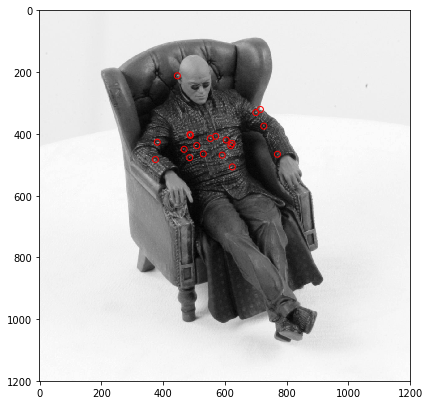

In [399]:
nms_resluts_2 = nms_2(check_2,windowSize)
n_corner_2 = n_strongest(nms_resluts_2,20)
corners_2 = np.array(list(zip(n_corner_2[1],n_corner_2[0])))
show_corners_result(grayimgs_mat[0],corners_2)

In [385]:
corners_2

array([[  0,   0],
       [715, 321],
       [700, 331],
       [726, 375],
       [487, 402],
       [488, 405],
       [570, 408],
       [553, 415],
       [604, 420],
       [381, 427],
       [623, 431],
       [509, 438],
       [619, 438],
       [468, 450],
       [530, 465],
       [770, 466],
       [591, 469],
       [486, 477],
       [375, 483],
       [624, 507]], dtype=int64)

In [386]:
corners

array([[446, 212],
       [715, 321],
       [700, 331],
       [726, 375],
       [487, 402],
       [488, 405],
       [570, 408],
       [553, 415],
       [604, 420],
       [381, 427],
       [623, 431],
       [509, 438],
       [619, 438],
       [468, 450],
       [530, 465],
       [770, 466],
       [591, 469],
       [486, 477],
       [375, 483],
       [624, 507]], dtype=int64)

In [316]:
def nlargest_indices(arr, n):
    uniques = np.unique(arr)
    threshold = uniques[-n]
    return np.where(arr > threshold)

def is_localMax(arr, i_red):
    if arr[i_red][i_red] == np.max(arr):
        return True
    else:
        return False

def imconv(img, operator):

    img_grad = np.zeros(img.shape)  
    rd = int((operator.shape[0]-1)/2)
    cd = int((operator.shape[1]-1)/2)
    row, col = img.shape

    for i in range(rd, row-rd):
        for j in range(cd, col-cd):
            img_grad[i][j] = (img[(i-rd):(i+rd+1),(j-cd):(j+cd+1)] * operator).sum()
    
    return img_grad

def corner_detect(image, nCorners, smoothSTD, windowSize):
    """Detect corners on a given image.

    Args:
        image: Given a grayscale image on which to detect corners.
        nCorners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for corner detector and non maximum suppression.

    Returns:
        Detected corners (in image coordinate) in a numpy array (n*2).

    
    """
    ### Your code here:
    i_red = int((windowSize-1)/2)
    img_smooth = gaussian_filter(image,sigma=smoothSTD)
    
    img_dy, img_dx = np.gradient(img_smooth)
    
    window = np.ones([windowSize,windowSize])
    
    img_dx2 = imconv(img_dx * img_dx, window)
    img_dy2 = imconv(img_dy * img_dy, window)
    img_dxy = imconv(img_dx * img_dy, window)
    
    lamda = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            c = np.array([[img_dx2[i][j], img_dxy[i][j]], [img_dxy[i][j], img_dy2[i][j]]])
            a, b = np.linalg.eig(c)
            lamda[i][j] = min(a)
    
    crns_candidates = np.array([[-1, -1]])
    crns_value = np.array([0])
            
    for i in range(i_red, image.shape[0]-i_red):
        for j in range(i_red, image.shape[1]-i_red):
            temp = lamda[i-i_red:i+i_red+1, j-i_red:j+i_red+1]
            if is_localMax(temp, i_red) == True:
                crns_value = np.row_stack((crns_value, [lamda[i][j]]))
                crns_candidates = np.row_stack((crns_candidates, [j, i]))
                
    x, y = nlargest_indices(crns_value, nCorners)
    corners = crns_candidates[x]
    return corners

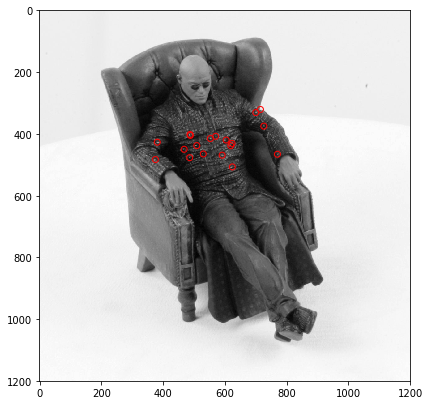

In [317]:
check_2 = corner_detect(grayimgs_mat[0], nCorners, smoothSTD, windowSize)
show_corners_result(grayimgs_mat[0],check_2)

In [383]:
check[0,0]

0.0

In [382]:
check_2[0,0]

27803.413860500004

In [393]:
a = np.pad(check_2,window_range,mode="reflect")

In [394]:
a[0:3,0:3]

array([[1.21190616e-15, 3.82835696e-27, 1.21190616e-15],
       [2.40736308e-27, 2.78034139e+04, 2.40736308e-27],
       [1.21190616e-15, 3.82835696e-27, 1.21190616e-15]])

In [396]:
check.max()

3049.637667756462

In [397]:
check_2.max()

27803.413860500004

In [2]:
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])

In [40]:
img1

array([[1, 2, 3, 4],
       [4, 5, 6, 8],
       [7, 8, 9, 4]])

In [41]:
zipped = list(zip(img1,img2))

In [42]:
zipped

[(array([1, 2, 3, 4]), array([1, 2, 1, 3])),
 (array([4, 5, 6, 8]), array([6, 5, 4, 4])),
 (array([7, 8, 9, 4]), array([9, 8, 7, 3]))]

In [38]:
np.where(img2[0]==1)

(array([0, 2], dtype=int64),)

In [39]:
img1.argmax(axis=1)

array([3, 3, 2], dtype=int64)

In [9]:
img2[]

array([[1, 2, 1, 3],
       [6, 5, 4, 4],
       [9, 8, 7, 3]])

In [10]:
img1*img2

array([[ 1,  4,  3, 12],
       [24, 25, 24, 32],
       [63, 64, 63, 12]])

In [35]:
img1.max(axis=1).reshape(1,3)

array([[4, 8, 9]])

In [5]:
img1-img1.mean()

array([[-4.08333333, -3.08333333, -2.08333333, -1.08333333],
       [-1.08333333, -0.08333333,  0.91666667,  2.91666667],
       [ 1.91666667,  2.91666667,  3.91666667, -1.08333333]])

In [23]:
np.sqrt(((img1-img1.mean())**2).sum())

8.421203397773187

In [27]:
a,b = img1.shape

In [29]:
a*b

12

In [30]:
np.std(img1, ddof=a*b-1)

8.421203397773187

In [13]:
c1, c2, R = np.array([1, 1]), np.array([1, 1]), 1
matching_score = 0
window_size = 2*R+1
w1_mean = img1.mean()
w2_mean = img2.mean()
w1_tail = (img1-w1_mean)/np.sqrt(((img1-img1.mean())**2).sum())
w2_tail = (img2-w2_mean)/np.sqrt(((img2-img2.mean())**2).sum())
matching_score = (w1_tail[c1[0]-R:c1[0],c1[1]+R:c1[1]]+w2_tail[c2[0]-R:c2[0],c2[1]+R:c2[1]]).sum()

In [15]:
w1_tail

array([[-0.48488715, -0.36613928, -0.2473914 , -0.12864353],
       [-0.12864353, -0.00989566,  0.10885222,  0.34634797],
       [ 0.22760009,  0.34634797,  0.46509584, -0.12864353]])

In [22]:
w1_tail[1,1]

-0.009895656166595953

In [20]:
w1_tail[c1[0]-R:c1[0]+R+1,c1[1]-R:c1[1]+R+1]

array([[-0.48488715, -0.36613928, -0.2473914 ],
       [-0.12864353, -0.00989566,  0.10885222],
       [ 0.22760009,  0.34634797,  0.46509584]])

In [18]:
c1[0]-R

0

In [19]:
c1[1]+R

2

In [ ]:
# You are free to modify code here, create your helper functions etc.
# detect corners on warrior and matrix sets
nCorners = 10 # Do this for 10, 20 and 30 corners
smoothSTD = 2
windowSize = 13

# read images and detect corners on images
imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []
for i in range(2):
    img_mat = imageio.imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat))
    # downsize your image in case corner_detect runs slow in test
    # imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    
    img_war = imageio.imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war))
    # imgs_war.append(rgb2gray(img_war)[::2, ::2])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))
# match corners
R = 15
NCCth = 0.7 # Put your threshold
matching_mat = naive_matching(imgs_mat[0]/255, imgs_mat[1]/255, crns_mat[0], crns_mat[1], R, NCCth)
matching_war = naive_matching(imgs_war[0]/255, imgs_war[1]/255, crns_war[0], crns_war[1], R, NCCth)
# plot matching result
def show_matching_result(img1, img2, matching):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(np.hstack((img1, img2)), cmap='gray') # two dino images are of different sizes, resize one before use
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.savefig('dino_matching.png')
    plt.show()

# Uncomment to show output
print("Number of Corners:", nCorners)
show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat)
show_matching_result(imgs_war[0], imgs_war[1], matching_war)